# Fine-Tuning for Semantic Segmentation

This notebook is for the project of STATS 507 at University of Michigan.

In this notebook, I'm going to fine tune a pretrained vision model for semantic segmentation on a custom dataset in PyTorch. Next, a LUT (Look-Up Table) filter will be applied on the image according to the segmentation result to preserve some "characteristic colors" such as colors of face and hair.

If one is interested in how to fine-tune the model, you may run all the code blocks one by one. If one is only interested in doing inference with the fine-tuned model and checking the application results, you can directly start from the **Inference** section. (Still make sure to run the first two code blocks to install all the necessary libraries.)

The report for this project can be found [here]().

### Model

This is a supervised learning task that is capable of generating a mask image from the input image. Each pixel in the mask will represent a specific class (e.g., face, hair, arms, background). This task, known as semantic segmentation, aims to partition an image at the pixel level into semantically coherent regions.

For the project, I chose Apple’s MobileViT+DeepLabV3-small model as the initial model. MobileViT was pre-trained on PASCAL VOC with a resolution of 512$\times$512, and a DeepLabV3 head is integrated for semantic segmentation tasks. This combination provides a strong starting point for building an efficient and accurate model. This model has a relatively small parameter size of 6.4 million, which makes it easier and more suitable for deployment on mobile devices with limited computational power.

### Dataset

I used the Human Parsing Data dataset for fine-tune, which consists of 17,706 samples of fashionably dressed individuals. Each sample includes a 600$\times$400 original image and a corresponding mask image. The mask has 18 categories that segment the image pixels into regions such as background, hair, face, arms, and legs. This dataset is highly suitable for this project as it provides detailed labels of human skin and hair, which is crucial for the task of fine-tuning the model. However, the large number of images in the dataset made the training process slow without hardware acceleration. To overcome this, I utilized the Great Lakes ARC at the university, leveraging CUDA GPU acceleration to speed up the training process.

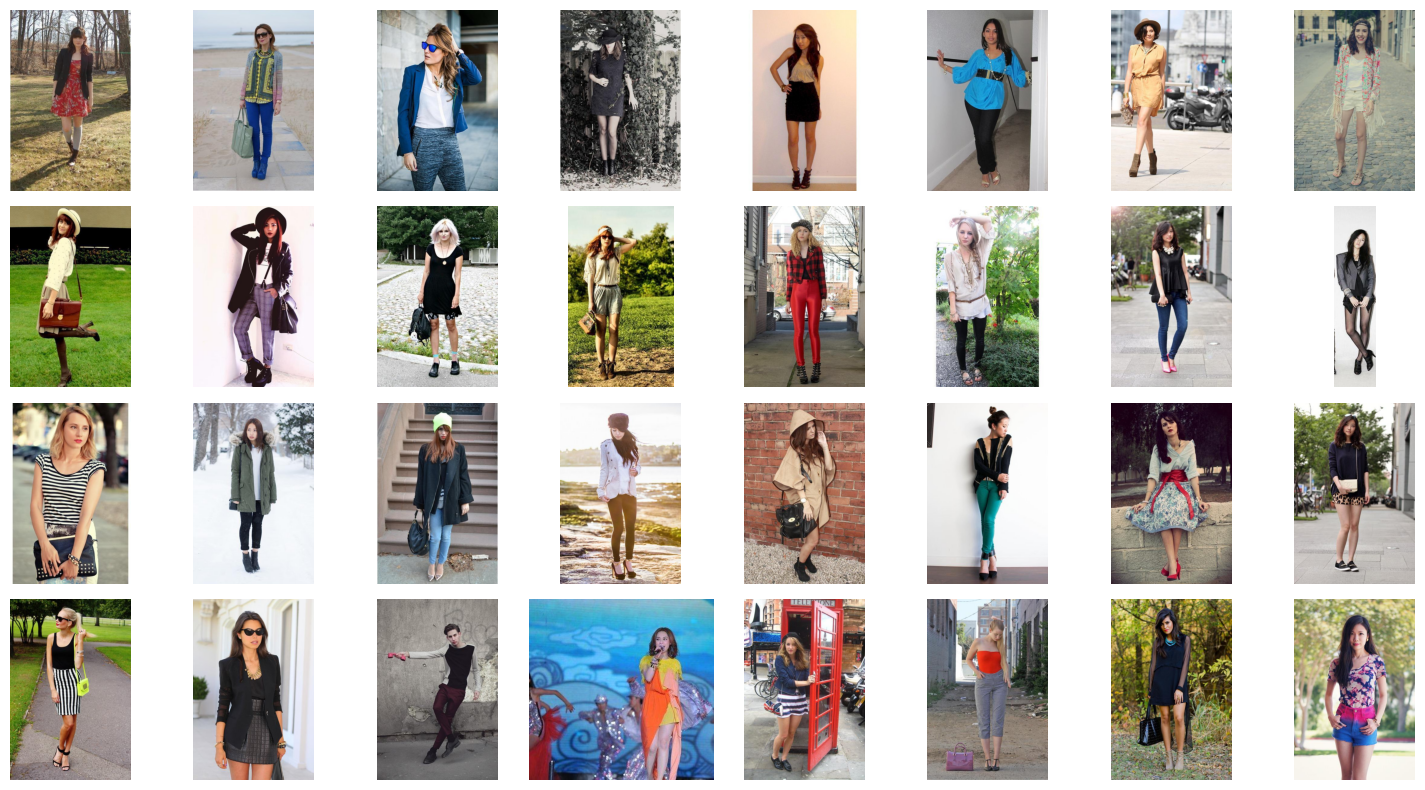

### Data Augmentation

This project leverages `albumentations` library for data augmentation. This allows simulating the randomness of data in real-world scenarios, enhancing the model's robustness and generalization ability.

Details can be found in **Preprocessing the Data** section.

# Code for Fine-Tuning

### Required Libraries

First, we need to install and load some libraries. One can just run the following blocks and it will automatically install all the necessary libraries.

In [ ]:
import importlib
import subprocess
import sys

# function to check and install the library
def check_and_install(package):
    try:
        importlib.import_module(package)
        print(f"'{package}' is already installed.")
    except ImportError:
        print(f"'{package}' is not installed. Installing now ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

In [ ]:
# check the necessary libraries
required_packages = ["numpy", "torch", "evaluate", "datasets", "transformers",
                     "albumentations", "pillow-lut", "matplotlib"]
for package in required_packages:
    check_and_install(package)

# load the libraries
import numpy as np
import torch
import evaluate        # evaluate the accuracy and performance
from torch import optim, nn        # core for neural network
from datasets import load_dataset        # load the dataset
# load the tokenizer and model
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from torch.utils.data import DataLoader        # shuffle and do batch processing
import albumentations as A        # enhance the images
import matplotlib.pyplot as plt        # visualize the training

'numpy' is already installed.
'torch' is already installed.
'evaluate' is already installed.
'datasets' is already installed.
'transformers' is already installed.
'albumentations' is already installed.
'pillow-lut' is not installed. Installing now ...
Defaulting to user installation because normal site-packages is not writeable
'matplotlib' is already installed.


### Loading the Dataset

We will use the [Datasets](https://github.com/huggingface/datasets) library to download the Human Parsing Data dataset from [Hugging Face](https://huggingface.co/datasets/mattmdjaga/human_parsing_dataset?row=0) into a [`DatasetDict`](https://huggingface.co/docs/datasets/v1.3.0/_modules/datasets/dataset_dict.html).

In [ ]:
# load the dataset
dataset_identifier = "mattmdjaga/human_parsing_dataset"
ds = load_dataset(dataset_identifier, split="train[:100%]", num_proc=8)

Here we check some basic information of this dataset.

In [ ]:
ds

Dataset({
    features: ['image', 'mask'],
    num_rows: 17706
})

There are 17706 samples in this dataset.

The `ds` object is a `DatasetDict`, which contains only the "train" split. But later we can split it into training and testing sets.

The `features` tell us that each sample is consisted of:

- `image`: the actual image
- `mask`: the segmentation mask

One example of the sample is shown down below.

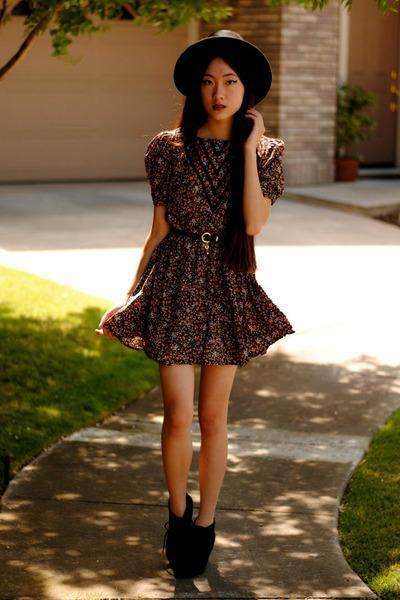

In [ ]:
example = ds[5]
example["image"]

And its corresponding mask image. It is a grayscale image, and Different shades of gray represent different categories.

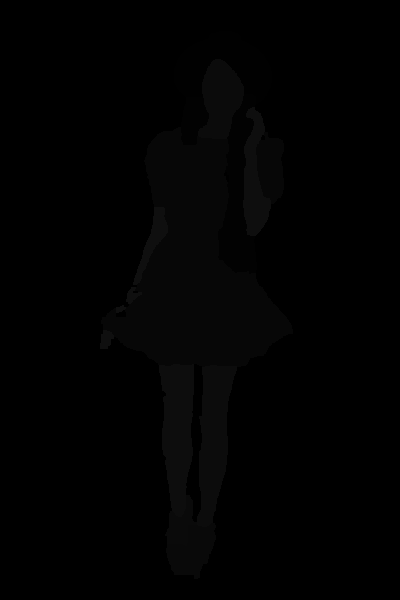

In [ ]:
example["mask"]

Each of the pixel in the above mask image is associated to a particular category. Here we define a dictionary `id2label` to decode them back to strings and see what they are. The inverse dictionary `label2id` is also useful when we fine-tune the model.

In [ ]:
# map from number to label
id2label = {
    "0": "Background",
    "1": "Hat",
    "2": "Hair",
    "3": "Sunglasses",
    "4": "Upper-clothes",
    "5": "Skirt",
    "6": "Pants",
    "7": "Dress",
    "8": "Belt",
    "9": "Left-shoe",
    "10": "Right-shoe",
    "11": "Face",
    "12": "Left-leg",
    "13": "Right-leg",
    "14": "Left-arm",
    "15": "Right-arm",
    "16": "Bag",
    "17": "Scarf",
}

# the inverse map
label2id = {v: k for k, v in id2label.items()}

# number of categories
num_labels = len(id2label)

Next we shuffle the dataset, and then split them into training and testing (validation) sets.

In [ ]:
ds.shuffle(seed=1)

# proportion for testing set
split_ratio = 0.006

ds_split = ds.train_test_split(test_size=split_ratio, seed=1)
train_ds = ds_split["train"]
test_ds = ds_split["test"]

split_size = len(test_ds)
print(f"Testing set size: {split_size}")

Testing set size: 107


There are 107 samples in testing set.

### Preprocessing the Data

Before we feed these images to the model, we apply a series of data augmentations to improve the model's ability to generalize. Data augmentation involves transforming the input images and their corresponding masks in various ways to simulate diverse scenarios in the real-world data and make the model more robust.

The augmentations in this pipeline include:

1. Flipping: Randomly flipping images horizontally with a 50% probability.
2. Noise and Quality Adjustments: Adding Gaussian noise or downscaling images to simulate low-quality inputs.
3. Color and Brightness Variations: Randomly altering brightness, contrast, saturation, and hue to simulate different lighting conditions.
4. Structural Distortions: Adding effects like pixel dropout or gravel noise to mimic real-world imperfections.

This augmentation process ensures that the model learns to handle a wide range of input variations, improving its performance and robustness in real-world scenarios.

In [ ]:
# image augmentation
img_transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),        # flip the image with prob 0.5
        A.OneOf(        # randomly select one to apply
            [
                A.Downscale(p=0.1, scale_min=0.4, scale_max=0.6),        # downscale the image
                A.GaussNoise(p=0.2)        # add Gaussian noise
                ], p=0.1,
        ),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=0.2),        # adjust the brightness and contrast
                A.ColorJitter(p=0.2),        # adjust the color
                A.HueSaturationValue(p=0.2)        # adjust the color
                ], p=0.1,
        ),
        A.OneOf(
            [
                A.PixelDropout(p=0.2),        # change the pixel to black or white
                A.RandomGravel(p=0.2)        # add noise
                ], p=0.15),
        ]
)

For training data, these transformations are applied randomly to increase variability. For validation data, no augmentations are used; only basic preprocessing is applied to ensure consistency in evaluation.

`set_transform` is a method in `dataset` to define the transformation logic applied to the data during iteration.

In [ ]:
# functions for transformations
def train_transforms(example_batch):
    # apply image augmentation
    trans = [
        img_transforms(image=np.array(x), mask=np.array(m))        # convert to numpy arrays
        for x, m in zip(example_batch["image"], example_batch["mask"])
    ]
    # extract the transformed images
    images = [x["image"] for x in trans]
    labels = [x["mask"] for x in trans]
    # send the data to feature extractor
    inputs = tokenizer(images, labels)
    return inputs

def val_transforms(example_batch):
  # extract the images
    images = [x for x in example_batch["image"]]
    labels = [x for x in example_batch["mask"]]
    # send the data to feature extractor
    inputs = tokenizer(images, labels)
    return inputs

train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

### Loading the Pre-Trained Model

We first define a class `TrainingConfig` configuration to manage the hyperparameters and settings. It will dynamically determine whether to use CUDA GPU acceleration or CPU.

- `batch_size`: Number of samples processed together in one forward and backward pass.
- `epochs`: Number of times going through the entire training set.
- `learning_rate`: The initial learning rate.
- `lr_decay_rate`: A factor by which the learning rate is multiplied at each step.
- `background_weight`: Penalty for misclassifying the background class.
- `other_classes_weight`: Penalty for misclassifying the non-background classes.
- `device`: Specify whether the training will run on CPU or GPU.


In [ ]:
class TrainingConfig:
    def __init__(
        self,
        batch_size=8,
        epochs=10,
        learning_rate=1e-4,
        background_weight=1.0,
        other_classes_weight=3.0,
        lr_decay_rate=0.9998,
        seed=1,
        model_name="apple/deeplabv3-mobilevit-small",
        device="cpu",
    ):
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.background_weight = background_weight
        self.other_classes_weight = other_classes_weight
        self.lr_decay_rate = lr_decay_rate
        self.seed = seed
        self.model_name = model_name
        self.device = device

if torch.cuda.is_available():
    print("Great! You have a powerful computer. CUDA GPU is available.")
    device = "cuda"
else:
    print("No! It gonna be slow. CPU is used instead.")
    device = "cpu"

config = TrainingConfig(device=device)

Great! You have a powerful computer. CUDA GPU is available.


Next, we load the pre-trained feature extractor (tokenizer) and model from [Hugging Face](https://huggingface.co/apple/deeplabv3-mobilevit-small). Note that the feature extractor in some model may crop the image, which is not what we want in image semantic segmentation task. One can disable this by setting `do_center_crop` to be false.

When loading the model, `ignore_mismatched_sizes` is enabled to handle dimensional discrepancies.

In [ ]:
# load the feature extractor and model
tokenizer = SegformerImageProcessor.from_pretrained(config.model_name)
# tokenizer.do_center_crop = False

model = AutoModelForSemanticSegmentation.from_pretrained(
    config.model_name, num_labels=num_labels,
    id2label=id2label, label2id=label2id,
    ignore_mismatched_sizes=True        # this will reinitialize the segmentation specific components
).to(config.device)

Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([18, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21]) in the checkpoint and torch.Size([18]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning here is telling us some weights (the weights and bias of the `segmentation_head` layer) are thrown away, which is in our expectation. The original model has 21 categories while our dataset only has 18. So the function warns us that we should fine-tune the model before using it for down-stream task.

Here we define a function to save the fine-tuned model.

In [ ]:
def save_model(model, tokenizer, name):
    model.save_pretrained(name)
    tokenizer.save_pretrained(name)

Here we define the data loader for the training and testing (validation) sets. The `train_loader` function will shuffle the data and group the images in batches for each training step. The `val_loader` is set up similarly but without shuffling, as it is used for evaluation.

In [ ]:
# DataLoader, optimizer, and scheduler
train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(test_ds, batch_size=config.batch_size, shuffle=False)

Next, we initialize the optimizer using AdamW, which is suitable for weight decay, and configure it with the model parameters and the learning rate specified in config. We also define a learning rate scheduler using a lambda function to apply exponential decay to the learning rate during training, as specified by `config.lr_decay_rate`. The scheduler will adjust the learning rate during training

In [ ]:
# optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)
lambda1 = lambda step: config.lr_decay_rate**step
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

Then we apply the penalty defined in `config` to the weights of the model. The CrossEntropyLoss is used as the loss function.

In [ ]:
# penalty for category
weights = torch.tensor(
    [config.background_weight] + [config.other_classes_weight] * 17
).to(config.device)
# loss function
loss_func = nn.CrossEntropyLoss(weight=weights)

### Evaluating the Performance

The validation function performs the inference on testing dataset, and return the inference results for later model evaluation.

In [ ]:
# validation on testing set
@torch.no_grad()
def validation(model, val_loader):

    model.eval()        # set the model to evaluation mode, which will disable dropout, etc.
    val_losses = []
    all_labels = []
    all_logits = []

    # iterate through the testing set
    for i, batch in enumerate(val_loader, 1):
        inputs = batch["pixel_values"].to(config.device)
        labels = batch["labels"].to(config.device)

        # inference on image
        outputs = model(inputs)
        # upsample the mask to the original size of the image
        logits_tensor = nn.functional.interpolate(
            outputs.logits,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )

        loss = loss_func(logits_tensor, labels)
        val_losses.append(loss.item())

        # move labels to CPU for memory efficiency
        all_labels.append(labels.cpu())
        all_logits.append(logits_tensor.cpu())

    # concatenate all the logits and labels
    logits = torch.cat(all_logits, dim=0).to(config.device)
    labels = torch.cat(all_labels, dim=0).to(config.device)

    model.train()
    return logits, labels, val_losses

Let's load the Mean IoU metric to evaluate the model during the training process.

Intersection over Union (IoU) is a commonly used evaluation metric for image segmentation tasks. It measures the overlap between the predicted segmentation mask and the ground truth mask as shown in the figure below. A higher IoU indicates better model performance, as it reflects a larger overlap between the predicted and actual regions of interest. IoU is particularly useful in tasks where the precise delineation of objects is important.

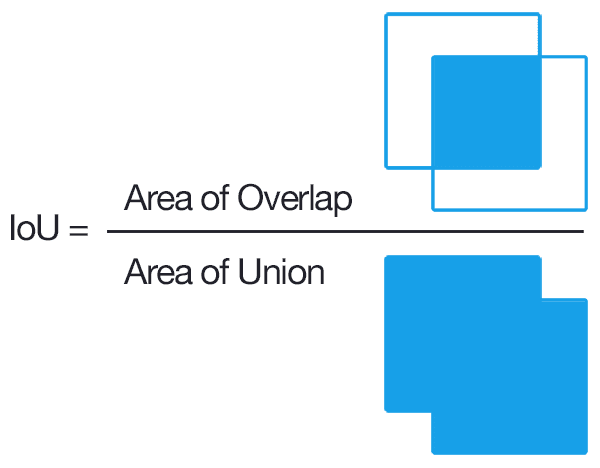

[Image Resource](https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

In [ ]:
# functions to evaluate performance
metric = evaluate.load("mean_iou")

@torch.no_grad()        # disable auto-gradient calculation
def compute_metrics(eval_pred):

    logits, labels = eval_pred
    # get the category prediction by the max logits for each pixel
    pred_labels = logits.argmax(dim=1)

    # calculate mean iou
    mets = metric.compute(
        predictions=pred_labels,
        references=labels,
        num_labels=num_labels,
        ignore_index=255,        # 255 is used for unknown or invalid pixels
        reduce_labels=False,        # do not aggregate across different labels
    )
    # covert the results into a list
    for key, value in mets.items():
        if type(value) is np.ndarray:
            mets[key] = value.tolist()

    return mets

### Fine-Tuning the Model

After all the preparations, we finally arrive at the step to fine-tune the segmenation model. Every 500 training steps, the model's performance is evaluated on the validation set.

In [ ]:
# some tracking variables
t_steps = 0
log_list = []
running_loss = []

for epoch in range(config.epochs):
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()        # reset the gradients in each step

        # move the data to device and do inference
        inputs = batch["pixel_values"].to(config.device)
        labels = batch["labels"].to(config.device)
        outputs = model(inputs)

        # upsample the mask to the original size of the image
        logits_tensor = nn.functional.interpolate(
            outputs.logits,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )

        loss = loss_func(logits_tensor, labels)
        running_loss.append(loss.item())

        loss.backward()        # backpropagate the gradients
        optimizer.step()       # update the weights
        scheduler.step()       # adjust the learning rate


        # print out the process of training
        if t_steps % 500 == 0:
            logs = {}
            last_lr = scheduler.get_last_lr()[0]        # current learning rate

            # validate the model and compute metrics on the testing set
            logits_tensor, labels, val_losses = validation(model, val_loader)
            r_loss = sum(running_loss) / len(running_loss)
            val_loss = sum(val_losses) / len(val_losses)

            # evaluation metrics
            mets = compute_metrics((logits_tensor, labels))

            logs["training_loss"] = r_loss
            logs["val_loss"] = val_loss

            for key, value in mets.items():
                if isinstance(value, float):
                    logs[key] = value

            print(f"\nEpoch {epoch} Iteration {i}")
            for key, score in logs.items():
                print(f"{key}: {score:.3f}")

            print(f"LR: {last_lr}")
            logs["LR"] = last_lr
            running_loss = []
            log_list.append(logs)

        t_steps += 1
    # save the model after each epoch
    save_model(model, tokenizer, f"model/epoch_{epoch}")

/home/sunjiaqi/.local/lib/python3.11/site-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")



Epoch 0 Iteration 0
training_loss: 8.571
val_loss: 6.068
mean_iou: 0.002
mean_accuracy: 0.052
overall_accuracy: 0.010
LR: 9.998e-05

Epoch 0 Iteration 500
training_loss: 1.975
val_loss: 1.215
mean_iou: 0.127
mean_accuracy: 0.189
overall_accuracy: 0.857
LR: 9.04647402826712e-05

Epoch 0 Iteration 1000
training_loss: 0.993
val_loss: 0.803
mean_iou: 0.181
mean_accuracy: 0.251
overall_accuracy: 0.881
LR: 8.18550633567829e-05

Epoch 0 Iteration 1500
training_loss: 0.753
val_loss: 0.657
mean_iou: 0.252
mean_accuracy: 0.328
overall_accuracy: 0.902
LR: 7.406478343061574e-05

Epoch 0 Iteration 2000
training_loss: 0.628
val_loss: 0.547
mean_iou: 0.316
mean_accuracy: 0.406
overall_accuracy: 0.916
LR: 6.701591715486038e-05

Epoch 1 Iteration 300
training_loss: 0.532
val_loss: 0.464
mean_iou: 0.350
mean_accuracy: 0.458
overall_accuracy: 0.922
LR: 6.063790298279111e-05

Epoch 1 Iteration 800
training_loss: 0.463
val_loss: 0.416
mean_iou: 0.378
mean_accuracy: 0.493
overall_accuracy: 0.925
LR: 5.4866

### Visualizing the Process

Here we visualize the learning process.

The first image plots th training loss and validation loss over iterations.

- Training Loss: This measures how well the model is fitting to the trainging dataset at each check point. A decreasing trend generally indicates that the model is learning effectively from the training data.
- Validation Loss: This measures the model's performance on the unseen testing data at each check point. It is almost always decreasing during the fine-tuning, indicating that we have not reached over-fitting.

Both losses decrease and stabilize at low values, indicating a good fine-tuning.

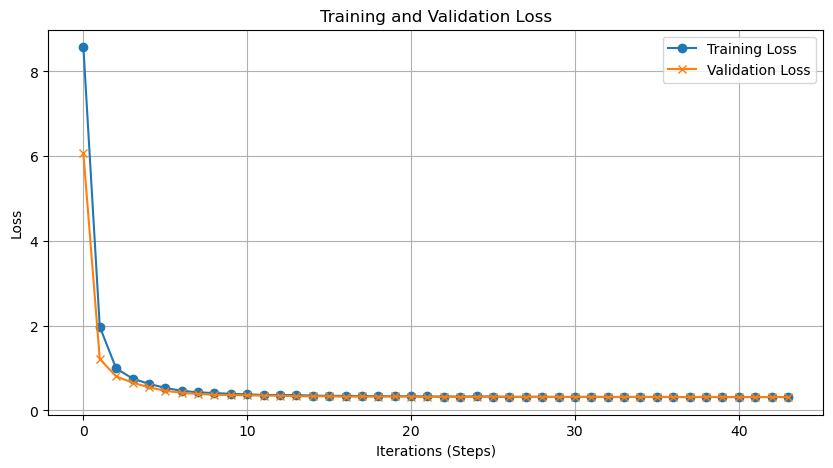

In [ ]:
epochs = list(range(len(log_list)))
training_losses = [log["training_loss"] for log in log_list]
val_losses = [log["val_loss"] for log in log_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, label="Training Loss", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", marker="x")
plt.xlabel("Iterations (Steps)")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

The learning rate during the fine-tuning is plotted below.

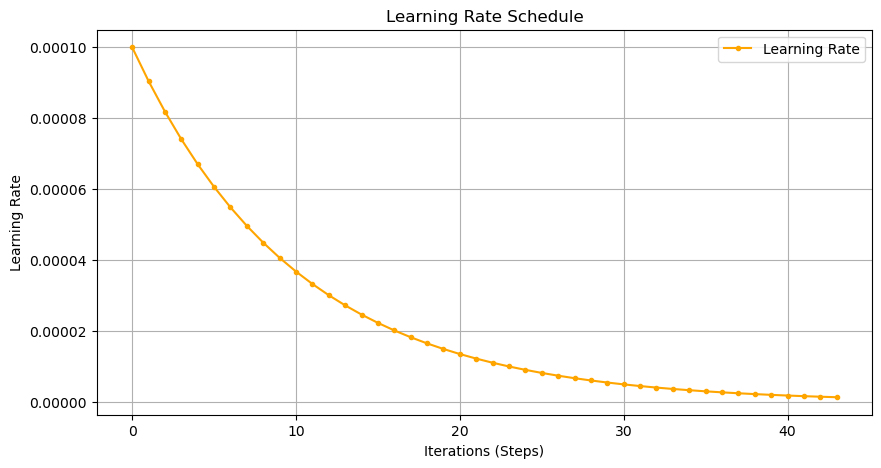

In [ ]:
learning_rates = [log["LR"] for log in log_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, learning_rates, label="Learning Rate", color="orange", marker=".")
plt.xlabel("Iterations (Steps)")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()

The plots below show the evolution of mean IoU, mean accuracy, and overall accuracy during the fine-tuning.

- Mean IoU: The average Intersection over Union over all the categories.
- Mean accuracy: The average proportion of correctly predicted pixels over all the categories.
- Overall accuracy: The proportion of correctly predicted pixels across all pixels.

The stabilization of overall accuracy around 0.93-0.94 indicates strong and consistent overall performance of the model. The relatively lower values in mean IoU and mean accuracy are primarily due to the uneven distribution of pixel quantities across different categories, with some categories having significantly fewer pixels than others. This imbalance makes it challenging for the model to achieve high performance uniformly across all categories.

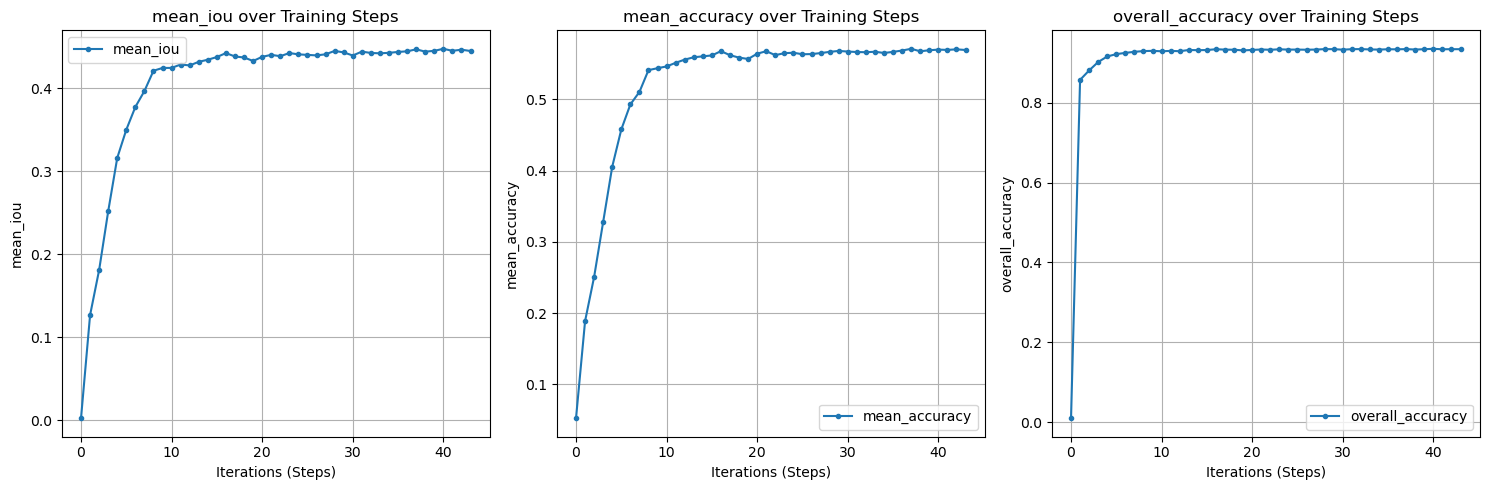

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metric_names = [key for key in log_list[0] if key not in ["training_loss", "val_loss", "LR"]]

# dictionary of metric names and their values
metrics = {name: [log[name] for log in log_list] for name in metric_names}

for i, (name, values) in enumerate(metrics.items()):
    axes[i].plot(epochs, values, label=name, marker=".")
    axes[i].set_xlabel("Iterations (Steps)")
    axes[i].set_ylabel(name)
    axes[i].set_title(f"{name} over Training Steps")
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# Inference

In this section, we will apply the fine-tuned model to a new image randomly selected from the internet, and compare the performance of the original model.

We first download the fine-tuned model and other necessary files from my GitHub.

In [ ]:
import os
import requests

# urls to files on github
config_url = "https://raw.githubusercontent.com/AlanGalaxy/stats507-coursework/refs/heads/main/model/config.json"
model_url = "https://github.com/AlanGalaxy/stats507-coursework/raw/main/model/model.safetensors"
preprocessor_url = "https://raw.githubusercontent.com/AlanGalaxy/stats507-coursework/refs/heads/main/model/preprocessor_config.json"
lut_url = "https://raw.githubusercontent.com/AlanGalaxy/stats507-coursework/refs/heads/main/resources/Kodak%20Professional%20Portra%20400.cube"
image_url = "https://github.com/AlanGalaxy/stats507-coursework/raw/main/resources/example.png"

# function to download
def download_file(url, save_path):
    if not os.path.exists(save_path):
        print(f"Downloading {url}...")
        response = requests.get(url)
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print(f"Saved to {save_path}")
    else:
        print(f"File already exists: {save_path}")


os.makedirs("resources", exist_ok=True)
os.makedirs("model", exist_ok=True)
download_file(config_url, "model/config.json")
download_file(model_url, "model/model.safetensors")
download_file(preprocessor_url, "model/preprocessor_config.json")
download_file(lut_url, "resources/Kodak Professional Portra 400.cube")
download_file(image_url, "resources/example.png")

Saved to model/config.json
Saved to model/model.safetensors
Saved to model/preprocessor_config.json
Saved to resources/Kodak Professional Portra 400.cube
Saved to resources/example.png


### Performance Comparison

Please run the first two code blocks under **Required Libraries** section to ensure you have the necessary libraries.

We first have a look of the performance of the original model before fine-tuning. Here we directly download the original model from [Hugging Face](https://huggingface.co/apple/deeplabv3-mobilevit-small).

In [ ]:
from transformers import MobileViTImageProcessor, AutoModelForSemanticSegmentation
from transformers import SegformerImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [ ]:
# apple model performance
model_name = "apple/deeplabv3-mobilevit-small"
processor = MobileViTImageProcessor.from_pretrained(model_name)
processor.do_center_crop = False
original_model = AutoModelForSemanticSegmentation.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# load the image
image = Image.open("./resources/example.png")

# pre-process the image
inputs = processor(images=image, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

# apply the model
outputs = original_model(**inputs)
logits = outputs.logits

# up sample the mask to the original size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

# get the segmentation result
pred_seg_original = upsampled_logits.argmax(dim=1)[0].cpu()

Then we plot the mask results by overlaying them on the original images with transparency, allowing us to clearly visualize the performance of semantic segmentation.

As the image below shows, the original model can only segment the person and the background in the image. It cannot distinguish finer details such as skin or body parts.

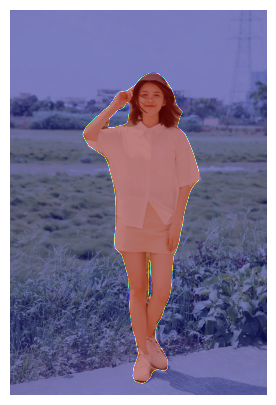

In [ ]:
# overlay the mask result on the image
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image)
ax.imshow(pred_seg_original, cmap="jet", alpha=0.5)  # transparent mask
ax.axis("off")
plt.show()

Next, we try the fine-tuned model after 10 epochs. We will load the model which we downloaded at the beginning of **Inference** section from my GitHub.

This time, the semantic segmentation result is much better. The fine-tuned model successfully segment different parts of the human body.

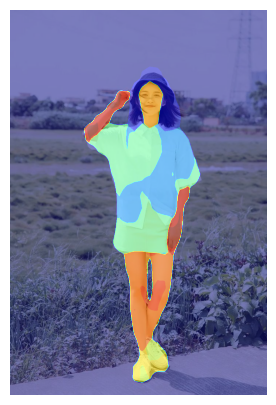

In [ ]:
# load the model from fine-tuning
model_dir = "./model"
processor = SegformerImageProcessor.from_pretrained(model_dir)
model = AutoModelForSemanticSegmentation.from_pretrained(model_dir).to("cuda" if torch.cuda.is_available() else "cpu")

# pre-process the image
inputs = processor(images=image, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

# apply the model
outputs = model(**inputs)
logits = outputs.logits

# up sample the mask to the original size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

# get the segmentation result
pred_seg = upsampled_logits.argmax(dim=1)[0].cpu()

# overlay the mask result on the image
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image)
ax.imshow(pred_seg, cmap="jet", alpha=0.5)  # transparent mask
ax.axis("off")
plt.show()

# Applying LUT to the Image

A LUT (Look-Up Table) is a structured data used to map input values to output values in a non-linear way. In our case, the values are colors. It is commonly used in image processing and color correction. By storing these transformations in a table, Luts allow for fast and efficient processing, enabling effects like color grading, contrast adjustment, or tone mapping without recalculating the transformations for each pixel individually.

Usually, a LUT is a matrix with many rows and three columns, where each row represents a color transformation, and each column corresponds to adjustments for the Red, Green, and Blue (RGB) channels.



```
0 0 0
0.0120546 0.00181582 0.00189212
0.0416571 0 1.5259e-05
0.0870985 0 0
0.1411 0 0
...
```



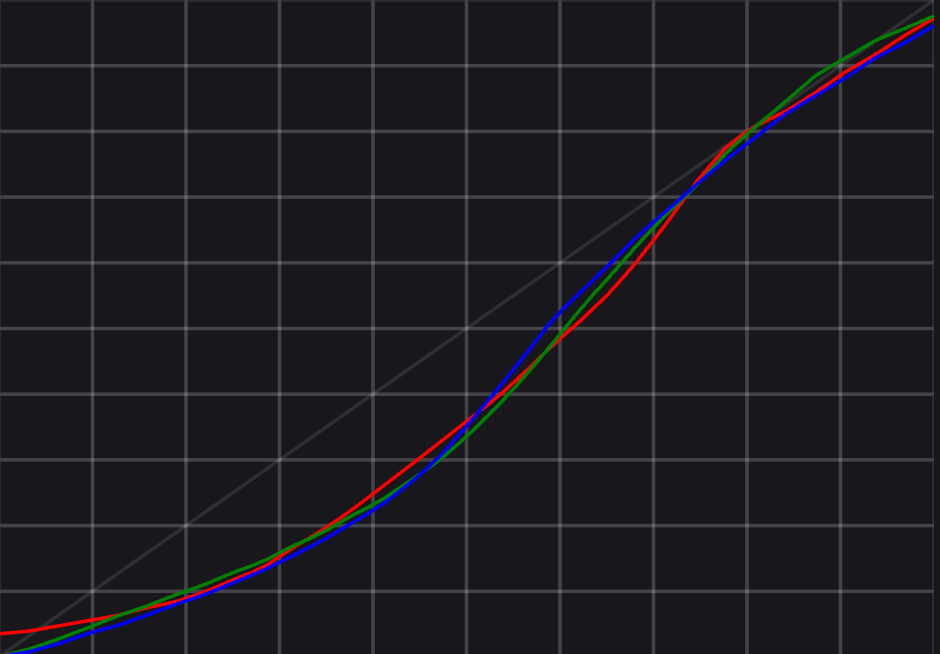

This is the original image.

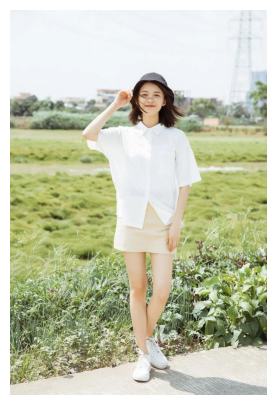

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image)
ax.axis("off")
plt.show()

Here we apply a LUT *Kodak Professional Portra 400* from Kodak to this image using library `PIL`. As one may see, the background is well adjusted. The color of the background becomes more vivid, and the overexposure was well controlled. On the other hand, the woman's skin tone has become dull and lackluster, which makes the photo less visually appealing.

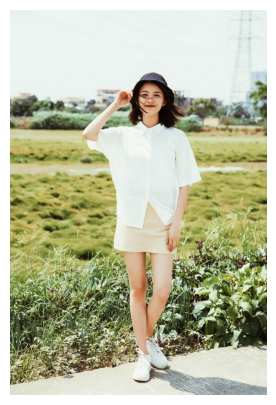

In [ ]:
from pillow_lut import load_cube_file

lut = load_cube_file("./resources/Kodak Professional Portra 400.cube")
image_with_lut = image.filter(lut)
image_with_lut.save("./resources/example_with_lut.png")

# plot the image with lut
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image_with_lut)
ax.axis("off")
plt.show()

Next, we combine the results of the image semantic segmentation, applying the LUT only to the non-skin areas and leaving the segmented skin regions unchanged. The resulting image shows a clear improvement, with the person's skin tone appearing normal, while the background remains vibrant. The final image is excellent.

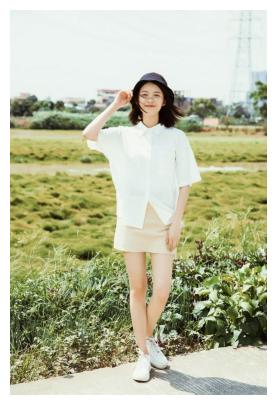

In [ ]:
# change the image into NumPy array
mask_array = np.array(pred_seg)
im_array = np.array(image)
im_lut_array = np.array(image_with_lut)

# categories for skin
categories_to_keep = [11, 12, 13, 14, 15]

# mask for skin
keep_mask = np.isin(mask_array, categories_to_keep)

final_image_array = np.where(keep_mask[..., None], im_array, im_lut_array)

# save and plot the image
final_image = Image.fromarray(final_image_array.astype('uint8'))
final_image.save("./resources/example_with_partial_lut.png")
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(final_image)
ax.axis("off")
plt.show()

This whole image processing is packed into one function `apply_partial_lut`. So next time we can simple call this function with path to the image and LUT as arguments to get the final image.

In [ ]:
def apply_partial_lut(image_path, model_dir="./model", lut_path="./resources/Kodak Professional Portra 400.cube"):
    processor = SegformerImageProcessor.from_pretrained(model_dir)
    model = AutoModelForSemanticSegmentation.from_pretrained(model_dir).to("cuda" if torch.cuda.is_available() else "cpu")

    # load the image
    image = Image.open(image_path).convert("RGB")

    # preprocess the image
    inputs = processor(images=image, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

    # apply the model
    outputs = model(**inputs)
    logits = outputs.logits

    # upsample the mask to the original size
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=image.size[::-1],
        mode="bilinear",
        align_corners=False,
    )

    # get the segmentation result
    pred_seg = upsampled_logits.argmax(dim=1)[0].cpu()

    # load the LUT
    lut = load_cube_file(lut_path)
    image_with_lut = image.filter(lut)

    # convert images and masks to NumPy arrays
    mask_array = np.array(pred_seg)
    im_array = np.array(image)
    im_lut_array = np.array(image_with_lut)

    # categories for skin
    categories_to_keep = [11, 12, 13, 14, 15]

    # create mask for skin
    keep_mask = np.isin(mask_array, categories_to_keep)

    # apply LUT to non-skin areas
    final_image_array = np.where(keep_mask[..., None], im_array, im_lut_array)

    # save and return the final image
    final_image = Image.fromarray(final_image_array.astype('uint8'))

    return final_image

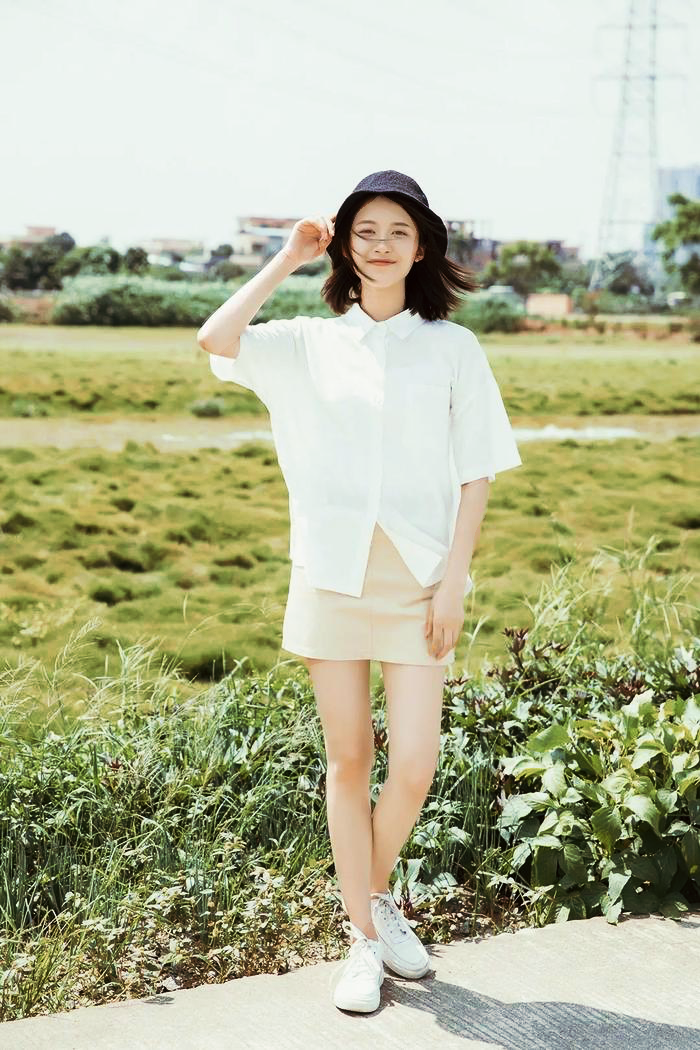

In [ ]:
apply_partial_lut(image_path="./resources/example.png", model_dir="./model", lut_path="./resources/Kodak Professional Portra 400.cube")

### Reference

The code for fine-tuning was modified based on this project: [Segformer B2 fine-tuned for clothes segmentation](https://huggingface.co/mattmdjaga/segformer_b2_clothes).